In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

df1 = pd.read_csv('datasets/반도체(831)_수출입통계(2011~2021).csv', encoding='utf-8')
df1.head()

,시점,수출 금액,수출 증감률,수입 금액,수입 증감률
0,2011.01,20373544,5.1,8445306,0.9
1,2011.02,16665092,-18.2,6262048,-25.9
2,2011.03,22197493,33.2,8478018,35.4
3,2011.04,19750481,-11.0,7857524,-7.3
4,2011.05,18849229,-4.6,7487074,-4.7


In [83]:
# 한글 깨짐

import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [84]:
df1 = df1[['시점', '수출 금액', '수입 금액']]
df1.reset_index(drop=True, inplace=True)
df1 = df1.rename(columns={'년월':'시점', '수출 금액':'수출액', '수입 금액':'수입액'})
df1

,시점,수출액,수입액
0,2011.01,20373544,8445306
1,2011.02,16665092,6262048
2,2011.03,22197493,8478018
3,2011.04,19750481,7857524
4,2011.05,18849229,7487074
...,...,...,...
127,2021.08,15057897,4499001
128,2021.09,15752184,4364291
129,2021.10,17222409,4201917
130,2021.11,16940429,4587520


In [85]:
dates = pd.date_range('2011-1-1', '2021-12-31', freq='M')
dates

DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', length=132, freq='M')

In [86]:
df1['시점'] = dates
df1

,시점,수출액,수입액
0,2011-01-31,20373544,8445306
1,2011-02-28,16665092,6262048
2,2011-03-31,22197493,8478018
3,2011-04-30,19750481,7857524
4,2011-05-31,18849229,7487074
...,...,...,...
127,2021-08-31,15057897,4499001
128,2021-09-30,15752184,4364291
129,2021-10-31,17222409,4201917
130,2021-11-30,16940429,4587520


In [87]:
df1.describe()

,수출액,수입액
count,1.320000e+02,1.320000e+02
mean,1.644245e+07,4.843965e+06
std,2.242078e+06,1.317828e+06
min,1.020776e+07,2.707382e+06
25%,1.496515e+07,3.795420e+06
50%,1.635859e+07,4.484471e+06
75%,1.787363e+07,5.715751e+06
max,2.224795e+07,8.478018e+06


**ARIMA (Auto Regressive Integrated Moving Average Model)**

In [88]:
# AD-Fuller Test : 시계열의 정상성 한지 확인
import statsmodels.tsa.api as tsa

# 수출액 데이터프레임
exports = df1[['시점', '수출액']]
exports_series = exports['수출액']
exports_df = exports.set_index('시점')
exports_df

,수출액
시점,
2011-01-31,20373544
2011-02-28,16665092
2011-03-31,22197493
2011-04-30,19750481
2011-05-31,18849229
...,...
2021-08-31,15057897
2021-09-30,15752184
2021-10-31,17222409


## ADF를 이용한 정상성 확인
* ARIMA 모델을 적용하기 전, 우선 시계열 데이터를 정상성 데이터를 바꾼 후 사용하는 것이 바람직함
* 정상성을 띄기 위해선 시계열 데이터의 평균, 분산이 시간에 따라 일정해야함
* lag에 따른 공분산이 일정해야함
* => 이를 위해 로그 변환을 해주거나 n차분을 적용함
* python에서는 ADF test를 statsmodels 라이브러리에서 adfuller를 이용하면 쉽게 구현 가능



* autolag='AIC' 또는 'BIC' : 'AIC' 또는 'BIC'가 가장 낮게 나오는 p를 자동으로 설정함. autolag를 지정할 경우 maxlag에서 지정한 값이 무시됨(maxlag의 디폴트값은 $12*(nobs/100)^1/4)$


## 시계열분석 (수출)

Text(0.5, 1.0, '반도체 수출액 시계열 시각화')

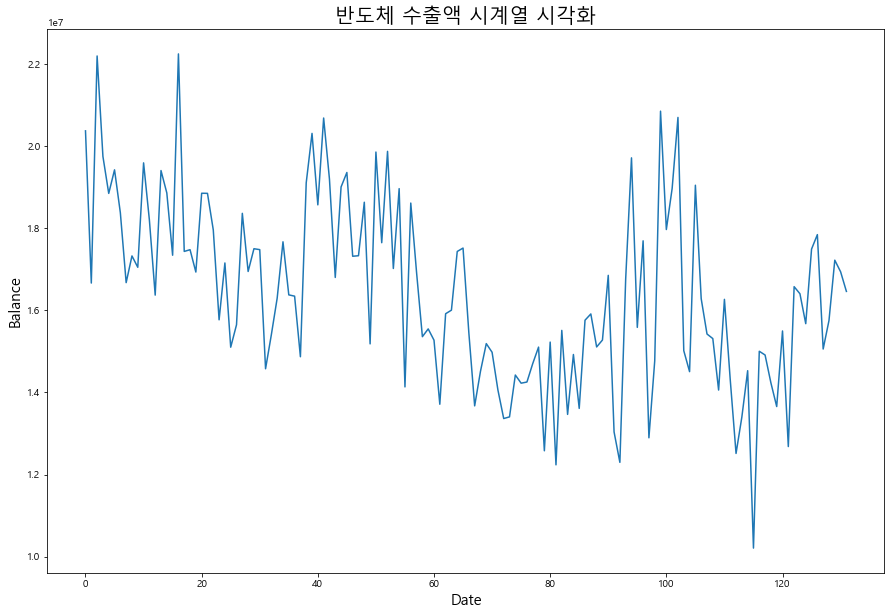

In [89]:
exports_amount = df1["수출액"]

# 그려보기
plt.figure(figsize=(15,10))
plt.plot(exports_amount)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Balance', fontsize=15)
plt.title('반도체 수출액 시계열 시각화', fontsize=20)

In [90]:
from statsmodels.tsa.stattools import adfuller

""" 차분 방법(바로 직전 데이터와의 차이) """
exports_df_diff = exports_df - exports_df.shift(1)
# print(exports_df)
# print(exports_df.shift(1))
# print(exports_df_diff)
# 2011 2월 수입액 - 2011 1월 수입액 이런식

y = exports_df.dropna()
y1diff = exports_df_diff.dropna()
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -2.363
원 데이터 p-value: 0.153
1차 차분 ADF Statistic: -6.109
1차 차분 p-value: 0.000


In [91]:
from pmdarima.arima import auto_arima

model_arima= auto_arima(y1diff,trace=True, error_action='ignore', d=1, start_p=0,start_q=0,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(y1diff)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4321.697, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4189.615, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4157.496, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4164.920, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4253.036, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4163.848, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4154.670, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4207.939, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4150.749, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4190.513, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4151.259, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(2,1,1)(0,0

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [92]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(y, order=(2,1,1))

model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.수출액   No. Observations:                  131
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2074.920
Method:                       css-mle   S.D. of innovations        1825146.718
Date:                Wed, 30 Mar 2022   AIC                           4159.839
Time:                        21:00:29   BIC                           4174.215
Sample:                    02-28-2011   HQIC                          4165.681
                         - 12-31-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.986e+04   4.67e+04     -0.639      0.523   -1.21e+05    6.18e+04
ar.L1.D.수출액    -0.0882      0.149     -0.593      0.553      -0.380       0.203
ar.L2.D.수출액    -0.0709      0.124     -0.570    

C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M wil

C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


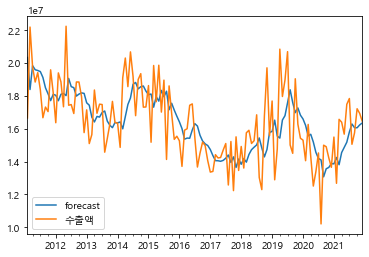

In [93]:
model_fit.plot_predict(dynamic=False)

plt.show()

In [94]:
dada=pd.date_range('2022-1-1', '2022-12-31', freq='M')

C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M wil

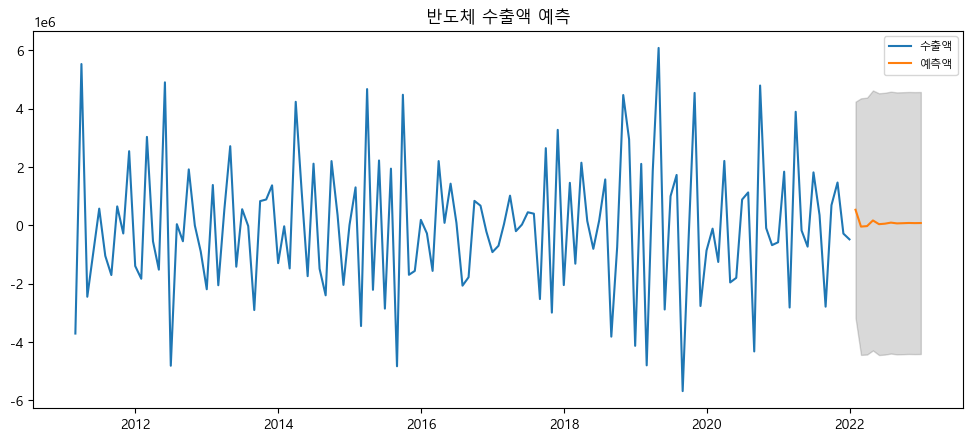

In [101]:
import datetime

model = ARIMA(y1diff, order=(2,1,1))
fitted = model.fit(disp=-1)

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=dada)
lower_series = pd.Series(conf[:, 0], index=dada)
upper_series = pd.Series(conf[:, 1], index=dada)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y1diff, label='수출액')
# plt.plot(dada, label='actual')
plt.plot(fc_series, label='예측액')
plt.title('반도체 수출액 예측')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [103]:
print(fc)
print(se)
print(conf)
print(lower_series)

[535924.57505065 -41764.9973162  -24444.06984158 169132.83314318
  41856.73662018  58199.47099688  94877.17131843  68317.4247806
  75101.18701373  82670.16614621  78075.44808312  80987.68131586]
[1890662.0141019  2244450.39466181 2247270.58121418 2274518.27685639
 2289778.49520118 2290242.05247345 2291103.5453497  2291795.30971991
 2291838.37069963 2291863.36788708 2291893.54578647 2291896.66380059]
[[-3169704.87952703  4241554.02962833]
 [-4440806.93594006  4357276.94130767]
 [-4429013.47253778  4380125.33285461]
 [-4288841.07167346  4627106.73795981]
 [-4446026.64654844  4529740.11978881]
 [-4430592.46773017  4546991.40972394]
 [-4395603.26241901  4585357.60505587]
 [-4423518.84220824  4560153.69176944]
 [-4416819.4779445   4567021.85197196]
 [-4409299.49239914  4574639.82469156]
 [-4413953.35805816  4570104.2542244 ]
 [-4411047.2360208   4573022.59865252]]
2022-01-31   -3.169705e+06
2022-02-28   -4.440807e+06
2022-03-31   -4.429013e+06
2022-04-30   -4.288841e+06
2022-05-31   -4.4460

In [ ]:
#######################################################################

In [1]:
# 아래의 코드는 사용 X

In [ ]:
# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['1968-%02d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

In [ ]:
# 에측
forecast = model.predict(last_1year)

In [ ]:
forecast.columns

In [ ]:
model.plot(forecast)
pyplot.show()

In [ ]:
# train set 이후 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['1969-%02d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

In [ ]:
forecast = model.predict(last_1year)
model.plot(forecast)
pyplot.show()

In [ ]:
# 마지막 12개월 제외시키기
train = df.drop(df.index[-12:])
y_true = df['y'][-12:].values

# 모델 생성 후 학습
model = Prophet()
model.fit(train)

# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['1968-%02d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = model.predict(last_1year)
y_pred = forecast['yhat'].values
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

In [ ]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#########

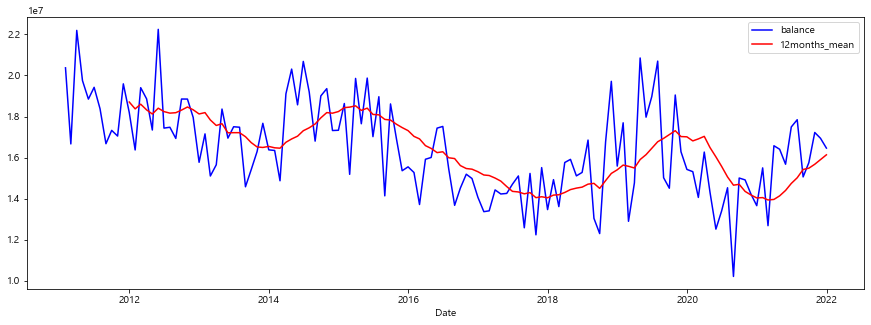

In [34]:
exports_df_mean = exports_df.rolling(window=12).mean()
exports_df_std = exports_df.rolling(window=12).std()

# rolling : 이동평균계산
# rolling(window=30).mean()의 경우, 30개를 평균내라
# 데이터가 (window=30) 30번째 이후인 값들부터 평균냄(30번째에 1~30번째까지의 평균을 구함)
# [참고] https://ordo.tistory.com/67

plt.figure(figsize = (15,5))
plt.xlabel('Date')
orig = plt.plot(exports_df, color='blue', label='balance')
mean = plt.plot(exports_df_mean, color='red', label='12months_mean')
plt.legend(loc='best')
plt.show()

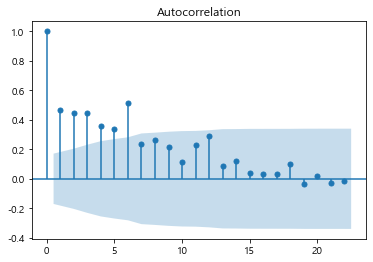

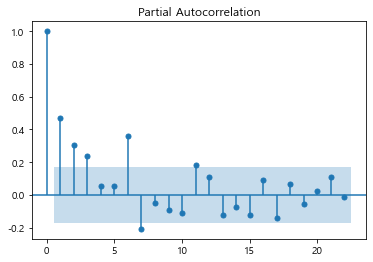

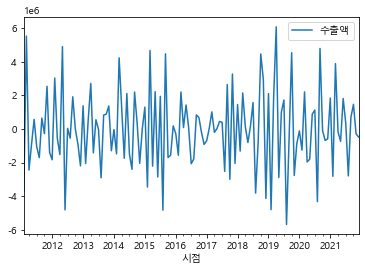

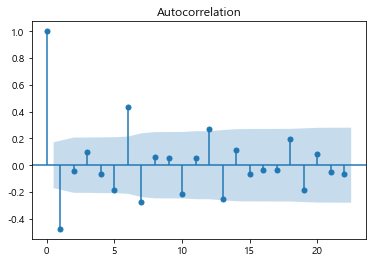

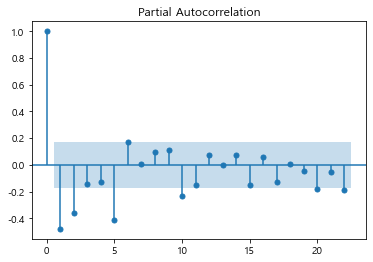

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y) # 차분 전. 시차1에 해당하는 ACF
plot_pacf(y) # 차분 전. 시차1차에 해당하는 PACF
plt.show()

diff_1=y.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1) # 차분 후. 시차2차에 해당하는 ACF
plot_pacf(diff_1) # 차분 후. 시차2차에 해당하는 PACF
plt.show()

C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\0528x\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M wil

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2075.242
Method:                       css-mle   S.D. of innovations        1829725.371
Date:                Wed, 30 Mar 2022   AIC                           4154.485
Time:                        09:26:49   BIC                           4160.235
Sample:                    02-28-2011   HQIC                          4156.821
                         - 12-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y     -0.7320      0.059    -12.384      0.000      -0.848      -0.616
                                    Roots                                    
                  Real          Imaginary           M

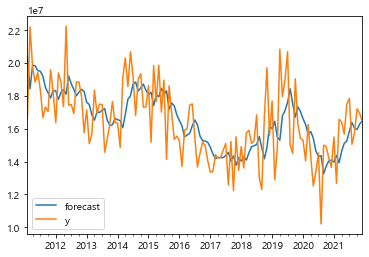

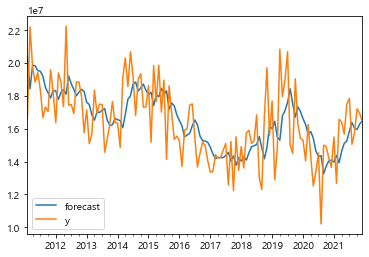

In [36]:
from statsmodels.tsa.arima_model import ARIMA
# MA(1)모델이 적합한 것으로 추정

exports_df =exports_df.sort_index(ascending=True)
exports_df = exports_df.dropna()
model = ARIMA(exports_df.values, order = (0,1,1), dates=(exports_df.index))
model_fit = model.fit(trend='nc',full_output=True, disp=True)
print(model_fit.summary())
model_fit.plot_predict()

(array([16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.36889697, 16467653.36889697,
       16467653.36889697, 16467653.3688

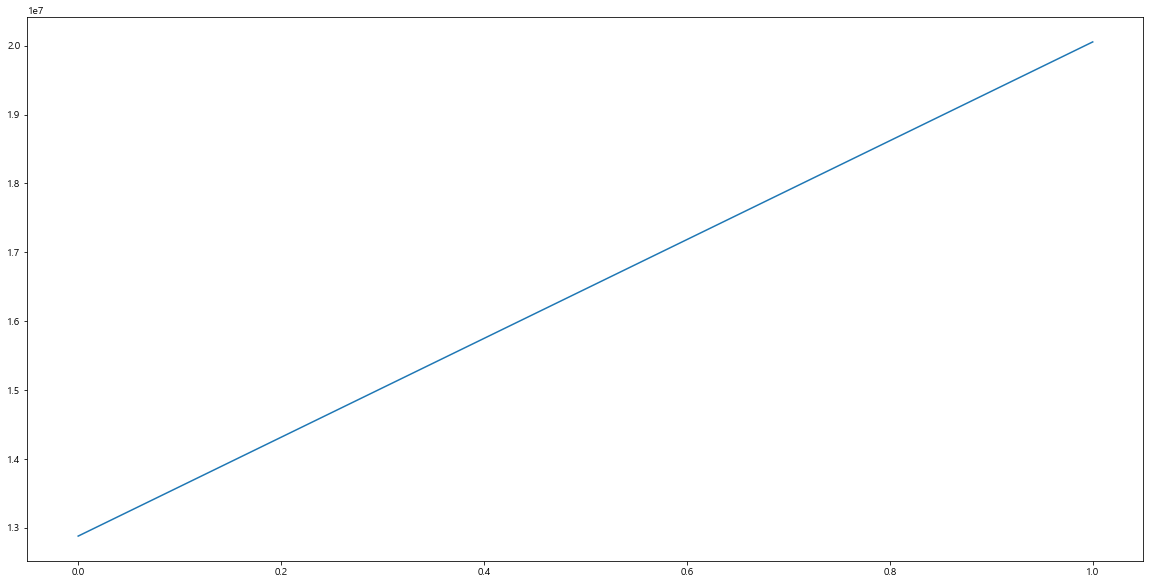

In [37]:
result = model_fit.forecast(steps=100)
plt.figure(figsize=(20,10))
print(result)
plt.plot(result[2][0])